# Imports

In [1]:
%matplotlib inline

from utils import (
    segment_and_renumber,
    haversine_m,
    create_seq2seq_sequences,
    plot_ship_trajectory_with_prediction,
    create_mmsi_dict_from_file
)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import random

In [ ]:
# PyTorch GPU check
if torch.cuda.is_available():
    print(f"\nPyTorch GPU detected!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    DEVICE = torch.device("cuda")
else:
    print("\nNo GPU detected for PyTorch. Using CPU.")
    DEVICE = torch.device("cpu")

print(f"\nUsing device: {DEVICE}")


✅ PyTorch GPU detected!
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU

Using device: cuda


# Fecthing data

In [3]:
file_name = "data/mmsi_type.txt"
mmsi_map = create_mmsi_dict_from_file(file_name)

if mmsi_map:
    print("--- Successfully created dictionary ---")

--- Successfully created dictionary ---


In [4]:
df = pd.read_csv("data/ais_combined_merged.csv")
df_with_types = df.copy()
df_with_types['Type'] = df_with_types['MMSI'].astype(str).map(mmsi_map)
allowed_type = ['Cargo ship', 'Cargo ship (HAZ-A)', 'Cargo ship (HAZ-B)', 'Cargo ship (HAZ-D)', 'Tanker', 'Tanker (HAZ-A)', 'Tanker (HAZ-B)', 'Tanker (HAZ-C)', 'Tanker (HAZ-D)']
df_cargo = df_with_types[df_with_types['Type'].isin(allowed_type)]

df_cargo = df_cargo.drop(columns=["Type"], axis= 1)


# Data Preprocessing

In [5]:
# Configuration Parameters
GAP_BREAK_MIN = 180
INTERPOLATION_LIMIT_MIN = 3
MAX_DISTANCE_M = 3000 # meters
MAX_SOG_KNOTS = 40 * 0.514444  # Convert knots to m/s
NUM_COLS = ["SOG", "COG", "Longtitude", "Latitude"]
MIN_SEGMENT_LENGTH = 35
INTERVAL = 5

### Check Stats

In [6]:
# Get cargo and tanker only dataset
df_cargo = df_cargo.sort_values(["MMSI", "Timestamp"]).reset_index(drop=True)
df_cargo["Timestamp"] = pd.to_datetime(df_cargo["Timestamp"], errors="coerce")
print(f"Initial data shape: {df_cargo.shape}")
print(f"Data types:\n{df_cargo.dtypes}\n")

Initial data shape: (1737515, 7)
Data types:
MMSI                   int64
SOG                  float64
COG                  float64
Longtitude           float64
Latitude             float64
Timestamp     datetime64[ns]
Segment                int64
dtype: object



### Segmentation

In [7]:
df = segment_and_renumber(df_cargo, GAP_BREAK_MIN)

### Downsampling & interpolation

In [8]:
results = []

for (mmsi, seg), g in df.groupby(["MMSI", "Segment"]):
    g = g.set_index("Timestamp")

    g1 = g.resample(f"{INTERVAL}min").last()
    
    # Cubic spline interpolation
    non_null_counts = g1[NUM_COLS].notnull().sum()
    min_points = non_null_counts.min()
    if min_points >= 4:
        g1_numeric_idx = g1.copy()
        g1_numeric_idx.index = (g1_numeric_idx.index - g1_numeric_idx.index[0]).total_seconds()

        g1_numeric_idx[NUM_COLS] = g1_numeric_idx[NUM_COLS].interpolate(
            method="spline", order=3, limit=INTERPOLATION_LIMIT_MIN, limit_direction="both"
        )

        g1[NUM_COLS] = g1_numeric_idx[NUM_COLS].values
    else:
        g1[NUM_COLS] = g1[NUM_COLS].interpolate(
            method="linear", limit=INTERPOLATION_LIMIT_MIN, limit_direction="both"
        )

    g1 = g1.dropna(subset=NUM_COLS, how="any")

    if len(g1) < 1:
        continue

    g1["COG"] = g1["COG"] % 360
    
    g1["MMSI"] = mmsi
    g1["Segment"] = seg

    lat = g1["Latitude"].to_numpy()
    lon = g1["Longtitude"].to_numpy()
    lat_prev = np.roll(lat, 1)
    lon_prev = np.roll(lon, 1)

    g1["distance_m"] = haversine_m(lat, lon, lat_prev, lon_prev)
    g1.loc[g1.index[0], "distance_m"] = 0.0
    
    g1 = g1[(g1["distance_m"] <= MAX_DISTANCE_M) & (g1["SOG"] <= MAX_SOG_KNOTS)]

    results.append(g1)

df_clean = pd.concat(results).reset_index()
print(f"Cleaned data shape: {df_clean.shape}")

d:\Program Files\SEM1\dl_maritime\.venv\lib\site-packages\pandas\core\missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


Cleaned data shape: (70343, 8)


### Data quality check

In [9]:
print(f"Rows before cleaning: {len(df_clean)}")

missing = df_clean[df_clean[NUM_COLS].isna().any(axis=1)]
print(f"Rows with missing numeric data: {len(missing)} ({len(missing)/len(df_clean)*100:.2f}%)")
print(f"MMSI with missing data: {missing['MMSI'].nunique()}")

Rows before cleaning: 70343
Rows with missing numeric data: 0 (0.00%)
MMSI with missing data: 0


In [10]:
df_clean = df_clean.dropna(subset=NUM_COLS+["MMSI", "Segment"])
print(f"Rows after cleaning: {len(df_clean)}")

Rows after cleaning: 70343


In [11]:
max_gap = df_clean.groupby(["MMSI", "Segment"])["Timestamp"].diff().dt.total_seconds().div(60).max()
print(f"Maximum time gap before re-segmentation: {max_gap:.2f} minutes")

Maximum time gap before re-segmentation: 885.00 minutes



### Re-segmentation

In [12]:
print(f"\nRe-segmenting based on gaps > {INTERVAL} minutes...")
df_clean = df_clean.sort_values(["MMSI", "Segment", "Timestamp"]).reset_index(drop=True)
df_clean = segment_and_renumber(df_clean, GAP_BREAK_MIN=5)

max_gap_after = df_clean.groupby(["MMSI","Segment"])["Timestamp"].diff().dt.total_seconds().div(60).max()
print(f"Maximum time gap after re-segmentation: {max_gap_after:.2f} minutes")


Re-segmenting based on gaps > 5 minutes...
Maximum time gap after re-segmentation: 5.00 minutes
Maximum time gap after re-segmentation: 5.00 minutes


### Segment length filtering

In [13]:
print(f"\nFiltering segments with < {MIN_SEGMENT_LENGTH} points...")
print(f"Segments before filtering: {df_clean.groupby(['MMSI', 'Segment']).ngroups}")
print(f"Rows before filtering: {len(df_clean)}")

segment_sizes = df_clean.groupby(["MMSI", "Segment"]).size()
valid_segments = segment_sizes[segment_sizes >= MIN_SEGMENT_LENGTH].index
df_clean = df_clean.set_index(["MMSI", "Segment"]).loc[valid_segments].reset_index()

print(f"Segments after filtering: {df_clean.groupby(['MMSI', 'Segment']).ngroups}")
print(f"Rows after filtering: {len(df_clean)}")


Filtering segments with < 35 points...
Segments before filtering: 873
Rows before filtering: 70343
Segments after filtering: 388
Rows after filtering: 67102


### Dataset summary

In [15]:
print(f"Total rows: {len(df_clean)}")
print(f"Unique vessels (MMSI): {df_clean['MMSI'].nunique()}")
print(f"Total segments: {df_clean.groupby(['MMSI', 'Segment']).ngroups}")
print(f"Average segment length: {df_clean.groupby(['MMSI', 'Segment']).size().mean()*INTERVAL:.1f} minutes")
print(f"Columns: {list(df_clean.columns)}")

Total rows: 67102
Unique vessels (MMSI): 272
Total segments: 388
Average segment length: 864.7 minutes
Columns: ['MMSI', 'Segment', 'Timestamp', 'SOG', 'COG', 'Longtitude', 'Latitude', 'distance_m']


In [16]:
df_clean["COG"].max()

np.float64(359.9936387398291)

# Preparing Dataset

In [17]:
# Configuration for Seq2Seq model training
SEQUENCE_LENGTH = 20
PREDICTION_HORIZON = 10
INTERVAL = 5

ORIGINAL_FEATURES = ["Latitude", "Longtitude", "SOG", "COG"]
INPUT_FEATURES = ["Latitude", "Longtitude", "delta_Lat", "delta_Lon", "SOG", "delta_COG"] 
TARGET_FEATURES = ["delta_Lat", "delta_Lon", "SOG", "delta_COG"]

MIN_SEGMENT_LENGTH = SEQUENCE_LENGTH + PREDICTION_HORIZON + 5

print(f"Input:  {SEQUENCE_LENGTH} timesteps ({SEQUENCE_LENGTH * INTERVAL} min history)")
print(f"Output: {PREDICTION_HORIZON} timesteps ({PREDICTION_HORIZON * INTERVAL} min prediction)")
print(f"Features: {len(INPUT_FEATURES)} input → {len(TARGET_FEATURES)} output per step")

Input:  20 timesteps (100 min history)
Output: 10 timesteps (50 min prediction)
Features: 6 input → 4 output per step


In [18]:
df_delta = df_clean.copy()

df_delta["COG"] = df_delta["COG"] % 360

# # Smooth COG by segment to reduce noise
df_delta['COG_smooth'] = df_delta.groupby(['MMSI', 'Segment'])['COG'].transform(
    lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
)

df_delta["delta_Lat"] = df_delta.groupby(["MMSI", "Segment"])["Latitude"].diff()
df_delta["delta_Lon"] = df_delta.groupby(["MMSI", "Segment"])["Longtitude"].diff()

df_delta["delta_COG"] = df_delta.groupby(["MMSI", "Segment"])["COG_smooth"].diff()

mask_180 = df_delta['delta_COG'] > 180
mask_neg180 = df_delta['delta_COG'] < -180

df_delta.loc[mask_180, 'delta_COG'] -= 360
df_delta.loc[mask_neg180, 'delta_COG'] += 360

# Remove the first point in each segment
df_delta = df_delta.dropna(subset=["delta_Lat", "delta_Lon", "delta_COG"])

In [19]:
print(f"Data shape after computing hybrid features: {df_delta.shape}")
print(f"\nDelta statistics (movement features):")
print(f"  delta_Lat - mean: {df_delta['delta_Lat'].mean():.6f}, std: {df_delta['delta_Lat'].std():.6f}")
print(f"  delta_Lon - mean: {df_delta['delta_Lon'].mean():.6f}, std: {df_delta['delta_Lon'].std():.6f}")
print(f"  delta_Lat range: [{df_delta['delta_Lat'].min():.6f}, {df_delta['delta_Lat'].max():.6f}]")
print(f"  delta_Lon range: [{df_delta['delta_Lon'].min():.6f}, {df_delta['delta_Lon'].max():.6f}]")
print(f"\ndelta_COG statistics (circular, -180° to +180°):")
print(f"  delta_COG - mean: {df_delta['delta_COG'].mean():.4f}°, std: {df_delta['delta_COG'].std():.4f}°")
print(f"  delta_COG range: [{df_delta['delta_COG'].min():.2f}°, {df_delta['delta_COG'].max():.2f}°]")

Data shape after computing hybrid features: (66714, 12)

Delta statistics (movement features):
  delta_Lat - mean: -0.000074, std: 0.008511
  delta_Lon - mean: 0.001331, std: 0.017118
  delta_Lat range: [-0.026041, 0.026260]
  delta_Lon range: [-0.049885, 0.050367]

delta_COG statistics (circular, -180° to +180°):
  delta_COG - mean: -0.0072°, std: 15.0054°
  delta_COG range: [-80.07°, 74.32°]


### Preparing sequences

In [20]:
# Create Seq2Seq sequences: input (20 steps) → output (10 steps)
X, y, segment_info = create_seq2seq_sequences(
    df_delta,
    SEQUENCE_LENGTH,
    PREDICTION_HORIZON,
    INPUT_FEATURES,
    TARGET_FEATURES,
    MIN_SEGMENT_LENGTH
)

print(f"\nInput shape: {X.shape}")
print(f"  - {X.shape[0]} sequences")
print(f"  - {X.shape[1]} input timesteps")
print(f"  - {X.shape[2]} features: {INPUT_FEATURES}")
print(f"\nTarget shape: {y.shape}")
print(f"  - {y.shape[0]} sequences")
print(f"  - {y.shape[1]} output timesteps (prediction horizon)")
print(f"  - {y.shape[2]} features: {TARGET_FEATURES}")
print(f"\nSegments used: {len(set((s['mmsi'], s['segment']) for s in segment_info))}")


Input shape: (55437, 20, 6)
  - 55437 sequences
  - 20 input timesteps
  - 6 features: ['Latitude', 'Longtitude', 'delta_Lat', 'delta_Lon', 'SOG', 'delta_COG']

Target shape: (55437, 10, 4)
  - 55437 sequences
  - 10 output timesteps (prediction horizon)
  - 4 features: ['delta_Lat', 'delta_Lon', 'SOG', 'delta_COG']

Segments used: 383


### Storing original last positions

In [21]:
# Store original positions for Seq2Seq evaluation
original_positions = []

for (mmsi, seg), g in df_delta.groupby(['MMSI', 'Segment']):
    if len(g) < MIN_SEGMENT_LENGTH:
        continue
    
    lats = g['Latitude'].values
    lons = g['Longtitude'].values
    cogs = g['COG'].values
    
    for i in range(len(g) - SEQUENCE_LENGTH - PREDICTION_HORIZON + 1):
        pos_record = {
            'last_lat': lats[i + SEQUENCE_LENGTH - 1],
            'last_lon': lons[i + SEQUENCE_LENGTH - 1],
            'last_cog': cogs[i + SEQUENCE_LENGTH - 1],
        }
        # Store target positions for all horizon steps
        for t in range(PREDICTION_HORIZON):
            pos_record[f'target_lat_{t}'] = lats[i + SEQUENCE_LENGTH + t]
            pos_record[f'target_lon_{t}'] = lons[i + SEQUENCE_LENGTH + t]
        
        original_positions.append(pos_record)

original_positions = pd.DataFrame(original_positions)
print(f"Stored {len(original_positions)} position records")

Stored 55437 position records


### Train test split

In [22]:
unique_mmsis = list(set([seg['mmsi'] for seg in segment_info]))
n_ships = len(unique_mmsis)

print(f"Total unique ships: {n_ships}")

mmsi_temp, mmsi_test = train_test_split(
    unique_mmsis, test_size=0.2, random_state=42, shuffle=True
)
mmsi_train, mmsi_val = train_test_split(
    mmsi_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nShips in training set: {len(mmsi_train)} ({len(mmsi_train)/n_ships*100:.1f}%)")
print(f"Ships in validation set: {len(mmsi_val)} ({len(mmsi_val)/n_ships*100:.1f}%)")
print(f"Ships in test set: {len(mmsi_test)} ({len(mmsi_test)/n_ships*100:.1f}%)")

mmsi_train_set = set(mmsi_train)
mmsi_val_set = set(mmsi_val)
mmsi_test_set = set(mmsi_test)

train_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_train_set]
val_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_val_set]
test_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_test_set]

X_train_raw = X[train_indices]
y_train_raw = y[train_indices]

X_val_raw = X[val_indices]
y_val_raw = y[val_indices]

X_test_raw = X[test_indices]
y_test_raw = y[test_indices]

original_positions_test = original_positions.iloc[test_indices].reset_index(drop=True)

print(f"\nSequences in training set: {X_train_raw.shape[0]} ({X_train_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Sequences in validation set: {X_val_raw.shape[0]} ({X_val_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Sequences in test set: {X_test_raw.shape[0]} ({X_test_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test positions: {len(original_positions_test)} records stored for evaluation")

Total unique ships: 272

Ships in training set: 173 (63.6%)
Ships in validation set: 44 (16.2%)
Ships in test set: 55 (20.2%)

Sequences in training set: 34684 (62.6%)
Sequences in validation set: 9058 (16.3%)
Sequences in test set: 11695 (21.1%)
Test positions: 11695 records stored for evaluation


# Normalize data

In [23]:
# Normalize data for Seq2Seq
n_samples_train, n_timesteps, n_features = X_train_raw.shape
n_target_steps = y_train_raw.shape[1]
n_target_features = y_train_raw.shape[2]

print(f"Input shape: ({n_samples_train}, {n_timesteps}, {n_features})")
print(f"Target shape: {y_train_raw.shape} (samples, horizon, features)")
print(f"Features: {INPUT_FEATURES}")

# Define feature indices
coords_indices = [0, 1]
delta_indices = [2, 3, 4, 5]

# Split features
X_train_coords = X_train_raw[:, :, coords_indices]
X_val_coords = X_val_raw[:, :, coords_indices]
X_test_coords = X_test_raw[:, :, coords_indices]

X_train_deltas = X_train_raw[:, :, delta_indices]
X_val_deltas = X_val_raw[:, :, delta_indices]
X_test_deltas = X_test_raw[:, :, delta_indices]

# Normalize coordinates (Lat, Lon)
X_train_coords_reshaped = X_train_coords.reshape(-1, len(coords_indices))

scaler_lat_lon = StandardScaler()
X_train_coords_normalized = scaler_lat_lon.fit_transform(X_train_coords_reshaped)
X_train_coords_normalized = X_train_coords_normalized.reshape(n_samples_train, n_timesteps, len(coords_indices))

X_val_coords_reshaped = X_val_coords.reshape(-1, len(coords_indices))
X_val_coords_normalized = scaler_lat_lon.transform(X_val_coords_reshaped).reshape(X_val_raw.shape[0], n_timesteps, len(coords_indices))

X_test_coords_reshaped = X_test_coords.reshape(-1, len(coords_indices))
X_test_coords_normalized = scaler_lat_lon.transform(X_test_coords_reshaped).reshape(X_test_raw.shape[0], n_timesteps, len(coords_indices))

print(f"Coordinate scaler stats:")
print(f"   Means: {scaler_lat_lon.mean_}")
print(f"   Stds: {scaler_lat_lon.scale_}")

# Normalize delta features
X_train_deltas_reshaped = X_train_deltas.reshape(-1, len(delta_indices))

scaler_X = StandardScaler()
X_train_deltas_normalized = scaler_X.fit_transform(X_train_deltas_reshaped)
X_train_deltas_normalized = X_train_deltas_normalized.reshape(n_samples_train, n_timesteps, len(delta_indices))

X_val_deltas_reshaped = X_val_deltas.reshape(-1, len(delta_indices))
X_val_deltas_normalized = scaler_X.transform(X_val_deltas_reshaped).reshape(X_val_raw.shape[0], n_timesteps, len(delta_indices))

X_test_deltas_reshaped = X_test_deltas.reshape(-1, len(delta_indices))
X_test_deltas_normalized = scaler_X.transform(X_test_deltas_reshaped).reshape(X_test_raw.shape[0], n_timesteps, len(delta_indices))

print(f"Delta scaler stats:")
print(f"   Means: {scaler_X.mean_}")
print(f"   Stds: {scaler_X.scale_}")

# Concatenate normalized coordinates + normalized deltas
X_train = np.concatenate([X_train_coords_normalized, X_train_deltas_normalized], axis=2)
X_val = np.concatenate([X_val_coords_normalized, X_val_deltas_normalized], axis=2)
X_test = np.concatenate([X_test_coords_normalized, X_test_deltas_normalized], axis=2)

# Normalize 3D targets: reshape to 2D, scale, reshape back
scaler_y = StandardScaler()
y_train_reshaped = y_train_raw.reshape(-1, n_target_features)
y_train_normalized = scaler_y.fit_transform(y_train_reshaped)
y_train = y_train_normalized.reshape(y_train_raw.shape[0], n_target_steps, n_target_features)

y_val_reshaped = y_val_raw.reshape(-1, n_target_features)
y_val = scaler_y.transform(y_val_reshaped).reshape(y_val_raw.shape[0], n_target_steps, n_target_features)

y_test_reshaped = y_test_raw.reshape(-1, n_target_features)
y_test = scaler_y.transform(y_test_reshaped).reshape(y_test_raw.shape[0], n_target_steps, n_target_features)

print(f"Target scaler stats:")
print(f"   Means: {scaler_y.mean_}")
print(f"   Stds: {scaler_y.scale_}")

print(f"\nFinal normalized shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape} (seq2seq output)")

Input shape: (34684, 20, 6)
Target shape: (34684, 10, 4) (samples, horizon, features)
Features: ['Latitude', 'Longtitude', 'delta_Lat', 'delta_Lon', 'SOG', 'delta_COG']
Coordinate scaler stats:Coordinate scaler stats:
   Means: [55.96591165 11.30491072]
   Stds: [1.10323788 2.00862477]
Delta scaler stats:
   Means: [-1.12896989e-04  2.31062929e-03  3.98687071e+00  2.07239892e-02]
   Stds: [8.83519939e-03 1.70775185e-02 2.75889574e+00 1.49469561e+01]

   Means: [55.96591165 11.30491072]
   Stds: [1.10323788 2.00862477]
Delta scaler stats:
   Means: [-1.12896989e-04  2.31062929e-03  3.98687071e+00  2.07239892e-02]
   Stds: [8.83519939e-03 1.70775185e-02 2.75889574e+00 1.49469561e+01]
Target scaler stats:
   Means: [-1.74899687e-04  2.36345112e-03  3.94615337e+00  2.76355060e-02]
   Stds: [8.74838895e-03 1.69977744e-02 2.76175096e+00 1.49292257e+01]

Final normalized shapes:
   X_train: (34684, 20, 6)
   y_train: (34684, 10, 4) (seq2seq output)
Target scaler stats:
   Means: [-1.74899687e

# Convert to Pytorch

In [24]:
X_train_tensor = torch.FloatTensor(X_train).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train).to(DEVICE)
X_val_tensor = torch.FloatTensor(X_val).to(DEVICE)
y_val_tensor = torch.FloatTensor(y_val).to(DEVICE)
X_test_tensor = torch.FloatTensor(X_test).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test).to(DEVICE)

BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Data moved to: {DEVICE}")

Training batches: 542
Validation batches: 142
Test batches: 183
Data moved to: cuda


# Model

In [ ]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_input_features, n_output_features, pred_horizon, 
                 encoder_hidden=128, decoder_hidden=64, n_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        
        self.pred_horizon = pred_horizon
        self.n_output_features = n_output_features
        self.decoder_hidden = decoder_hidden
        self.n_layers = n_layers
        
        # Encoder
        self.encoder = nn.LSTM(
            n_input_features, encoder_hidden, 
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Bridge
        self.bridge_h = nn.Linear(encoder_hidden, decoder_hidden)
        self.bridge_c = nn.Linear(encoder_hidden, decoder_hidden)
        
        # Decoder
        self.decoder = nn.LSTM(
            n_output_features, decoder_hidden,
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Output projection
        self.fc_out = nn.Sequential(
            nn.Linear(decoder_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, n_output_features)
        )
        
    def forward(self, x, teacher_forcing_ratio=0.0, target=None):
        batch_size = x.size(0)
        
        # Encode input sequence
        encoder_out, (encoder_h, encoder_c) = self.encoder(x)
        # encoder_h, encoder_c: [n_layers, batch, hidden]
        
        # Bridge to decoder hidden size
        # Take last layer's hidden and cell states
        decoder_h = torch.tanh(self.bridge_h(encoder_h[-1])).unsqueeze(0)  # [1, batch, decoder_hidden]
        decoder_c = torch.tanh(self.bridge_c(encoder_c[-1])).unsqueeze(0)  # [1, batch, decoder_hidden]
        decoder_h = decoder_h.repeat(self.n_layers, 1, 1)  # [n_layers, batch, decoder_hidden]
        decoder_c = decoder_c.repeat(self.n_layers, 1, 1)  # [n_layers, batch, decoder_hidden]
        
        # Initialize decoder input
        decoder_input = torch.zeros(batch_size, 1, self.n_output_features).to(x.device)
        
        # Generate output sequence
        outputs = []
        for t in range(self.pred_horizon):
            decoder_out, (decoder_h, decoder_c) = self.decoder(decoder_input, (decoder_h, decoder_c))
            # decoder_out: [batch, 1, decoder_hidden]
            
            output = self.fc_out(decoder_out.squeeze(1))  # [batch, n_output_features]
            outputs.append(output)
            
            # Prepare next decoder input
            if target is not None and random.random() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = output.unsqueeze(1)
        
        # Stack outputs: [batch, pred_horizon, n_output_features]
        outputs = torch.stack(outputs, dim=1)
        return outputs

model = Seq2SeqLSTM(
    n_input_features=len(INPUT_FEATURES),
    n_output_features=len(TARGET_FEATURES),
    pred_horizon=PREDICTION_HORIZON,
    encoder_hidden=128,
    decoder_hidden=64,
    n_layers=2,
    dropout=0.3
).to(DEVICE)

print(model)
print(f"\nModel moved to: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seq2SeqLSTM(
  (encoder): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
  (bridge_h): Linear(in_features=128, out_features=64, bias=True)
  (bridge_c): Linear(in_features=128, out_features=64, bias=True)
  (decoder): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_out): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

Model moved to: cuda
Total parameters: 273,860
Trainable parameters: 273,860


### Training components

In [ ]:
OUTPUT_DIR = "models/lstm_enc_dec"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

PATIENCE = 20

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

INITIAL_TF_RATIO = 0.5
TF_DECAY = 0.95

print("\nSeq2Seq Training components configured:")
print(f"  - Loss: Smooth L1 (Huber) over {PREDICTION_HORIZON} steps")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  - Teacher Forcing: {INITIAL_TF_RATIO} → decays by {TF_DECAY}/epoch")
print(f"  - Early Stopping: patience={PATIENCE}")
print(f"  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)")

Output directory: models/lstm_enc_dec

Seq2Seq Training components configured:
  - Loss: Smooth L1 (Huber) over 10 steps
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Teacher Forcing: 0.4 → decays by 0.9/epoch
  - Early Stopping: patience=20
  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)

Seq2Seq Training components configured:
  - Loss: Smooth L1 (Huber) over 10 steps
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Teacher Forcing: 0.4 → decays by 0.9/epoch
  - Early Stopping: patience=20
  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)


### Training model

In [27]:
EPOCHS = 1000

history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'lr': [],
    'teacher_forcing': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
teacher_forcing_ratio = INITIAL_TF_RATIO

print(f"Training Seq2Seq LSTM ({PREDICTION_HORIZON}-step prediction)")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_X, teacher_forcing_ratio=teacher_forcing_ratio, target=batch_y)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    # Validation (no teacher forcing)
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Decay teacher forcing
    teacher_forcing_ratio = max(0.0, teacher_forcing_ratio * TF_DECAY)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    history['teacher_forcing'].append(teacher_forcing_ratio)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        
        torch.save(best_model_state, f'{OUTPUT_DIR}/best_model.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f} ✓")
    else:
        patience_counter += 1
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

# Save final model and history
torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_model.pth')
with open(f'{OUTPUT_DIR}/training_history.json', 'w') as f:
    json.dump(history, f)

print(f"\nModel saved to: {OUTPUT_DIR}/best_model.pth")

Training Seq2Seq LSTM (10-step prediction)
Epoch 1/1000 - loss: 0.1281 - mae: 0.2964 - val_loss: 0.0936 - val_mae: 0.2230 - tf: 0.360 ✓
Epoch 1/1000 - loss: 0.1281 - mae: 0.2964 - val_loss: 0.0936 - val_mae: 0.2230 - tf: 0.360 ✓
Epoch 3/1000 - loss: 0.0943 - mae: 0.2307 - val_loss: 0.0921 - val_mae: 0.2227 - tf: 0.292 ✓
Epoch 3/1000 - loss: 0.0943 - mae: 0.2307 - val_loss: 0.0921 - val_mae: 0.2227 - tf: 0.292 ✓
Epoch 4/1000 - loss: 0.0939 - mae: 0.2289 - val_loss: 0.0916 - val_mae: 0.2286 - tf: 0.262 ✓
Epoch 4/1000 - loss: 0.0939 - mae: 0.2289 - val_loss: 0.0916 - val_mae: 0.2286 - tf: 0.262 ✓
Epoch 5/1000 - loss: 0.0948 - mae: 0.2307 - val_loss: 0.0972 - val_mae: 0.2329 - tf: 0.236
Epoch 5/1000 - loss: 0.0948 - mae: 0.2307 - val_loss: 0.0972 - val_mae: 0.2329 - tf: 0.236
Epoch 6/1000 - loss: 0.0967 - mae: 0.2347 - val_loss: 0.0882 - val_mae: 0.2021 - tf: 0.213 ✓
Epoch 6/1000 - loss: 0.0967 - mae: 0.2347 - val_loss: 0.0882 - val_mae: 0.2021 - tf: 0.213 ✓
Epoch 9/1000 - loss: 0.0981 - m

### Training history

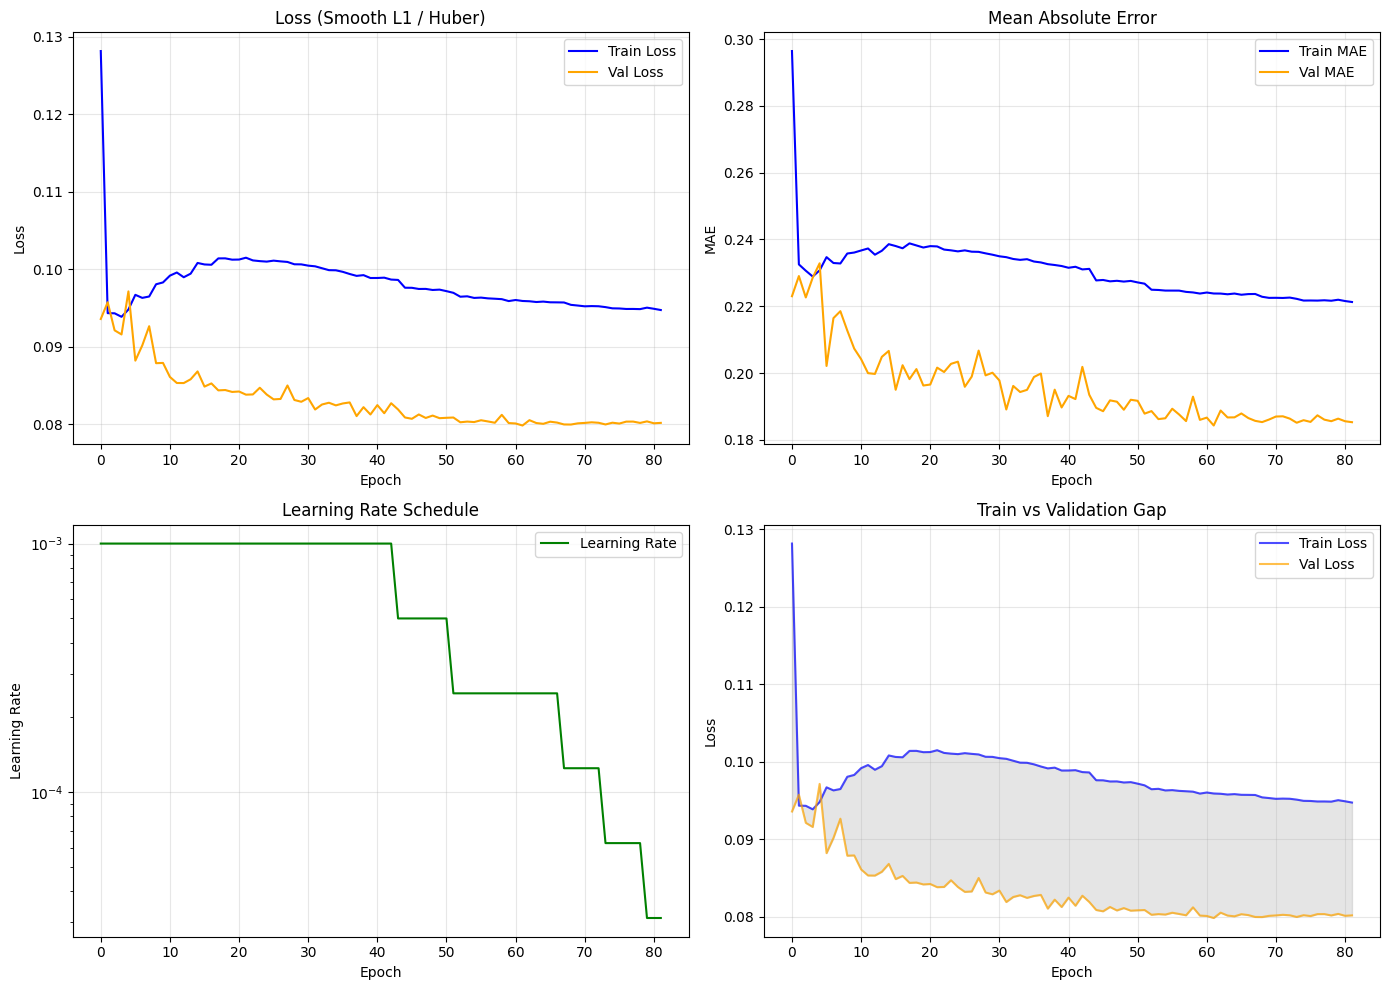


Training Summary:
  Total epochs: 82
  Best val_loss: 0.0799 (epoch 62)
  Final train_loss: 0.0948
  Final val_loss: 0.0802
  Final train_mae: 0.2213
  Final val_mae: 0.1853

Plot saved to: models/lstm_enc_dec/plots/training_history.png


In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Loss (Smooth L1 / Huber)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Train vs Val Loss comparison
axes[1, 1].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[1, 1].plot(history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
axes[1, 1].fill_between(range(len(history['train_loss'])), 
                         history['train_loss'], history['val_loss'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_title('Train vs Validation Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/training_history.png', dpi=150)
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best val_loss: {min(history['val_loss']):.4f} (epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
print(f"  Final train_mae: {history['train_mae'][-1]:.4f}")
print(f"  Final val_mae: {history['val_mae'][-1]:.4f}")
print(f"\nPlot saved to: {OUTPUT_DIR}/plots/training_history.png")

# Evaluation on test set

In [29]:
model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_model.pth'))
model.eval()
print(f"Loaded best Seq2Seq model from {OUTPUT_DIR}")

Loaded best Seq2Seq model from models/lstm_enc_dec


### Predict

In [30]:
# Evaluate Seq2Seq on test set
all_preds = []
all_targets = []
test_loss = 0.0
test_mae = 0.0

print(f"Evaluating {PREDICTION_HORIZON}-step Seq2Seq predictions...")

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        outputs = model(batch_X, teacher_forcing_ratio=0.0)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_mae /= len(test_loader)

print(f"\nTest Loss: {test_loss:.6f}")
print(f"Test MAE (normalized): {test_mae:.6f}")

Evaluating 10-step Seq2Seq predictions...


Testing: 100%|██████████| 183/183 [00:04<00:00, 43.00it/s]


Test Loss: 0.111638
Test MAE (normalized): 0.215641


In [31]:
# Stack and inverse transform Seq2Seq predictions
# Shape: [N, PREDICTION_HORIZON, 4]
y_pred_normalized = np.concatenate(all_preds, axis=0)
y_true_normalized = np.concatenate(all_targets, axis=0)

print(f"Predictions shape: {y_pred_normalized.shape}")
print(f"  - {y_pred_normalized.shape[0]} samples")
print(f"  - {y_pred_normalized.shape[1]} timesteps")
print(f"  - {y_pred_normalized.shape[2]} features")
    
n_samples, n_steps, n_feats = y_pred_normalized.shape
y_pred_raw = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)
y_true_raw = scaler_y.inverse_transform(y_true_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)

print(f"Inverse transformed to raw values")

Predictions shape: (11695, 10, 4)
  - 11695 samples
  - 10 timesteps
  - 4 features
Inverse transformed to raw values


### Convert deltas back to positions

In [32]:
# Convert Seq2Seq deltas to absolute positions for all horizon steps
last_lats = original_positions_test['last_lat'].values
last_lons = original_positions_test['last_lon'].values

pred_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
pred_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))

for t in range(PREDICTION_HORIZON):
    if t == 0:
        pred_lat_abs_all[:, t] = last_lats + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = last_lons + y_pred_raw[:, t, 1]
    else:
        pred_lat_abs_all[:, t] = pred_lat_abs_all[:, t-1] + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = pred_lon_abs_all[:, t-1] + y_pred_raw[:, t, 1]
    
    # True positions from stored original_positions
    true_lat_abs_all[:, t] = original_positions_test[f'target_lat_{t}'].values
    true_lon_abs_all[:, t] = original_positions_test[f'target_lon_{t}'].values

print(f"Converted to absolute positions for all {PREDICTION_HORIZON} steps")
print(f"   Prediction range: {PREDICTION_HORIZON * INTERVAL} minutes into future")

Converted to absolute positions for all 10 steps
   Prediction range: 50 minutes into future


### Calculate statistics

In [33]:
# Calculate distance errors per horizon step
print(f"\n{'Step':<8} {'Time':>8} {'Mean Dist':>12} {'Median':>10} {'90th %':>10}")
print("="*55)

distance_errors_per_step = []
for t in range(PREDICTION_HORIZON):
    dist_errors = haversine_m(
        pred_lat_abs_all[:, t], pred_lon_abs_all[:, t],
        true_lat_abs_all[:, t], true_lon_abs_all[:, t]
    )
    distance_errors_per_step.append(dist_errors)
    
    time_min = (t + 1) * INTERVAL
    print(f"Step {t+1:<3} {time_min:>5} min {np.mean(dist_errors):>10.1f} m {np.median(dist_errors):>8.1f} m {np.percentile(dist_errors, 90):>8.1f} m")

# Calculate per-feature metrics on first step
pred_delta_lat = y_pred_raw[:, 0, 0]
pred_delta_lon = y_pred_raw[:, 0, 1]
pred_sog = y_pred_raw[:, 0, 2]
pred_delta_cog = y_pred_raw[:, 0, 3]

true_delta_lat = y_true_raw[:, 0, 0]
true_delta_lon = y_true_raw[:, 0, 1]
true_sog = y_true_raw[:, 0, 2]
true_delta_cog = y_true_raw[:, 0, 3]

print(f"\n{'Feature':<15} {'MAE':>12} {'RMSE':>12}")
print("-" * 40)

# delta_Lat
dlat_mae = np.mean(np.abs(pred_delta_lat - true_delta_lat))
dlat_rmse = np.sqrt(np.mean((pred_delta_lat - true_delta_lat)**2))
print(f"{'delta_Lat':<15} {dlat_mae:>12.6f} {dlat_rmse:>12.6f}")

# delta_Lon
dlon_mae = np.mean(np.abs(pred_delta_lon - true_delta_lon))
dlon_rmse = np.sqrt(np.mean((pred_delta_lon - true_delta_lon)**2))
print(f"{'delta_Lon':<15} {dlon_mae:>12.6f} {dlon_rmse:>12.6f}")

# SOG
sog_mae = np.mean(np.abs(pred_sog - true_sog))
sog_rmse = np.sqrt(np.mean((pred_sog - true_sog)**2))
print(f"{'SOG':<15} {sog_mae:>12.6f} {sog_rmse:>12.6f}")

# delta_COG
dcog_mae = np.mean(np.abs(pred_delta_cog - true_delta_cog))
dcog_rmse = np.sqrt(np.mean((pred_delta_cog - true_delta_cog)**2))
print(f"{'delta_COG':<15} {dcog_mae:>12.4f}° {dcog_rmse:>12.4f}°")


Step         Time    Mean Dist     Median     90th %
Step 1       5 min      106.9 m     44.8 m    267.3 m
Step 2      10 min      200.6 m     87.2 m    512.5 m
Step 3      15 min      309.9 m    132.5 m    797.7 m
Step 4      20 min      448.5 m    191.5 m   1174.6 m
Step 5      25 min      608.8 m    255.5 m   1622.2 m
Step 6      30 min      787.8 m    325.1 m   2095.5 m
Step 7      35 min      985.7 m    409.7 m   2649.4 m
Step 8      40 min     1198.4 m    502.0 m   3254.2 m
Step 9      45 min     1424.8 m    594.5 m   3917.6 m
Step 10     50 min     1664.0 m    690.5 m   4645.3 m

Feature                  MAE         RMSE
----------------------------------------
delta_Lat           0.000589     0.001351
delta_Lon           0.001148     0.002573
SOG                 0.153733     0.324106
delta_COG             7.3416°      17.4319°


In [34]:
print(f"\n   Test Loss (Huber): {test_loss:.6f}")
print(f"   Test MAE (norm):   {test_mae:.6f}")


   Test Loss (Huber): 0.111638
   Test MAE (norm):   0.215641
